# Navigation

---

Congratulations for completing the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)!  In this notebook, you will learn how to control an agent in a more challenging environment, where it can learn directly from raw pixels!  **Note that this exercise is optional!**

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
from dqn_agent import Agent
from collections import deque

import torch
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline
%config IPCompleter.greedy=True

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/VisualBanana.app"`
- **Windows** (x86): `"path/to/VisualBanana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/VisualBanana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/VisualBanana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/VisualBanana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `VisualBanana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="VisualBanana.app")
```

In [2]:
env = UnityEnvironment(file_name="./VisualBanana_Windows_x86_x64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The environment state is an array of raw pixels with shape `(1, 84, 84, 3)`.  *Note that this code differs from the notebook for the project, where we are grabbing **`visual_observations`** (the raw pixels) instead of **`vector_observations`**.* A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

Number of agents: 1
Number of actions: 4
States look like:


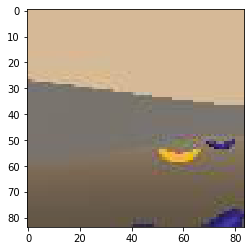

States have shape: (1, 84, 84, 3)


In [4]:
from PIL import Image

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.visual_observations[0]
# print(np.squeeze(state).shape)
print('States look like:')
plt.imshow(np.squeeze(state))
plt.show()
state_size = state.shape
print('States have shape:', state.shape)

In [5]:
from collections import deque

def augment_state(frames, actions):
    action_t_minus_1, action_t = actions[-1], actions[0]
    pix_t_minus_1 = frames[0]
    pix_t = frames[1]
    pix_t_plus_1 = frames[2]
    
    
    action_t_minus_1 = np.ones((84, 84)) * action_t_minus_1
    action_t = np.ones((84, 84)) * action_t
           
    state = np.stack([
        pix_t_minus_1[:,:,0], 
        pix_t_minus_1[:,:,1], 
        pix_t_minus_1[:,:,2], 
        
        action_t_minus_1, 
        
        pix_t[:,:,0], 
        pix_t[:,:,1], 
        pix_t[:,:,2], 
        
        action_t,
        
        pix_t_plus_1[:,:,0], 
        pix_t_plus_1[:,:,1], 
        pix_t_plus_1[:,:,2], 
    ])
    
    
    return state

def dqn(n_episodes=2000, max_t=100, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        framebuffer = deque(maxlen=3)
        action_buffer = deque(maxlen=2)
        env_info = env.reset(train_mode=True)[brain_name]
        # get initial 3-frame observation
        state = np.squeeze(env_info.visual_observations[0])
        for i in range(0, 3):
            framebuffer.append(state)
        for i in range(0, 2):
            action_buffer.append(0)
        
        state = augment_state(list(framebuffer), list(action_buffer))
        
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps).astype(int)
            action_buffer.append(action)
            env_info = env.step(action)[brain_name]
            framebuffer.append(np.squeeze(env_info.visual_observations[0]))
            next_state = augment_state(list(framebuffer), list(action_buffer))
            reward = env_info.rewards[0]
            done = env_info.local_done[0] or env.global_done
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
#             torch.save(agent.qnetwork_local.state_dict(), "visual_q_network.pth")
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    return scores


In [6]:
def train_dqn(n_episodes):
    scores = dqn(n_episodes=n_episodes)
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

Episode 100	Average Score: 0.29
Episode 200	Average Score: 0.96
Episode 300	Average Score: 1.81
Episode 400	Average Score: 2.07
Episode 500	Average Score: 2.54
Episode 600	Average Score: 2.87
Episode 700	Average Score: 2.92
Episode 800	Average Score: 2.98
Episode 900	Average Score: 3.41
Episode 1000	Average Score: 3.74
Episode 1100	Average Score: 3.89
Episode 1200	Average Score: 3.67
Episode 1300	Average Score: 3.67
Episode 1400	Average Score: 3.57
Episode 1500	Average Score: 3.50
Episode 1600	Average Score: 4.08
Episode 1700	Average Score: 3.21
Episode 1800	Average Score: 3.38
Episode 1900	Average Score: 3.38
Episode 2000	Average Score: 3.32
Episode 2100	Average Score: 3.30
Episode 2200	Average Score: 2.66
Episode 2300	Average Score: 2.92
Episode 2400	Average Score: 3.42
Episode 2500	Average Score: 2.92
Episode 2600	Average Score: 3.21
Episode 2700	Average Score: 3.28
Episode 2800	Average Score: 3.86
Episode 2900	Average Score: 3.60
Episode 3000	Average Score: 3.50


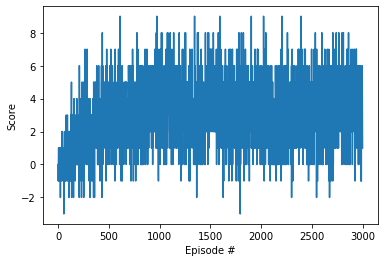

In [7]:
from model import VisualQNetwork

agent = Agent(state_size=state_size, action_size=action_size, seed=0, double=False, priority_replay=False, q_network=VisualQNetwork)
agent.qnetwork_local.load_state_dict(torch.load("visual_q_network.pth"))
agent.qnetwork_target.load_state_dict(torch.load("visual_q_network.pth"))
train_dqn(n_episodes=3000)

In [8]:
torch.save(agent.qnetwork_target.state_dict(), "visual_q_network.pth")

In [9]:
agent.qnetwork_target.summary()

AttributeError: 'VisualQNetwork' object has no attribute 'summary'

In [ ]:
from torchsummary import summary

In [ ]:
summary(agent.qnetwork_target, input_size=(64, 11, 84, 84))